In [22]:
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
from IPython.display import clear_output

import numpy as np

In [23]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")


TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [24]:
GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 100
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.99

In [25]:
state_dim=1
action_dim=2
intermediate_dim=16

In [26]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_dim)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        # model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])
        model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [27]:
class DQNSolver:
    def __init__(self, all_states,state_space,action_space, decay_coe = 0.99, 
                  memory_size = MEMORY_SIZE,EXPLORATION_DECAY=EXPLORATION_DECAY,LEARNING_RATE=LEARNING_RATE,EPSILON_MAX=EPSILON_MAX,EPSILON_MIN=EPSILON_MIN,BATCH_SIZE=BATCH_SIZE):
    
        #self.env = gym.make('CartPole-v0')
        self.all_states=all_states
        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        self.exploration_decay=EXPLORATION_DECAY
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.exploration_decay
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done,subsidy):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done,subsidy])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_dim)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_dim)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print(future_qvalue)

            for index, (state, action, reward, state_, done,subsidy) in enumerate(SARS):
                if done == True:
                    Qtarget = reward +(1-action)*(subsidy)
                else:
                    Qtarget = reward +(1-action)*(subsidy) + np.max(future_qvalue[index][0])-np.array(self.model.Qpolicy.predict_on_batch((self.state_shape(self.all_states)).reshape(len(self.all_states),1,state_dim))).sum()/10
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            


                
  

In [28]:
P_0_matrix=np.array([[0.1,0.9,0,0,0],
                   [0.1,0,0.9,0,0],
                   [0.1,0,0,0.9,0],
                   [0.1,0,0,0,0.9],
                   [0.1,0,0,0,0.9]])
P_0_matrix


array([[0.1, 0.9, 0. , 0. , 0. ],
       [0.1, 0. , 0.9, 0. , 0. ],
       [0.1, 0. , 0. , 0.9, 0. ],
       [0.1, 0. , 0. , 0. , 0.9],
       [0.1, 0. , 0. , 0. , 0.9]])

In [29]:
P_1_matrix=np.array([[1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0]])
P_1_matrix

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [30]:
action_space=[0,1]
state_space=[0,1,2,3,4]
A=0.9
reward_matrix=[[A**1,0],[A**2,0],[A**3,0],[A**4,0],[A**5,0]]
N=10
M=2
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [31]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [32]:
dqn_solver=DQNSolver(all_states=state_space,state_space=state_dim,action_space=action_dim)


In [33]:
current_state=[0 for _ in range(N)]
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [34]:
for i in range(1,2001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  # alpha=1/(1+(i/5000))
  beta=1/(1+(i*np.log(i)/5000))
  print(i)
  # if(i%1000==0):
  #    print(i)
  for index in arm_indexes:
      # print(index)
      # action=np.argmax(Q_values[index][current_state[index]])
      s=np.reshape(current_state[index],(1,state_dim))
      action=dqn_solver.act(s)
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      s_=np.reshape(new_state,(1,state_dim))
      reward=x[1]
      dqn_solver.remember(s, action, reward, s_, False,subsidy)
      dqn_solver.train()
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  #print(reward_sum)
  dqn_solver.update_target_model()
  dqn_solver.decrement_epsilon()
  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  epsilon=epsilon*gamma
  if epsilon<=0.01:
    epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  clear_output(wait=True)







2000


In [35]:
dqn_solver.all_states

[0, 1, 2, 3, 4]

Text(0.5, 1.0, 'Subsidy vs Steps for Restart Example')

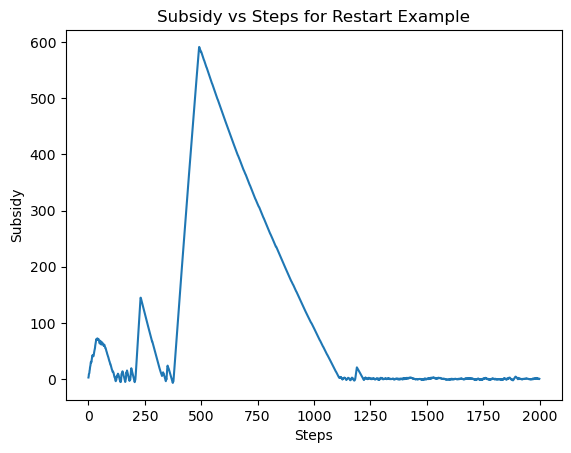

In [36]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Restart Example')

In [37]:
df=pd.DataFrame(rewards)


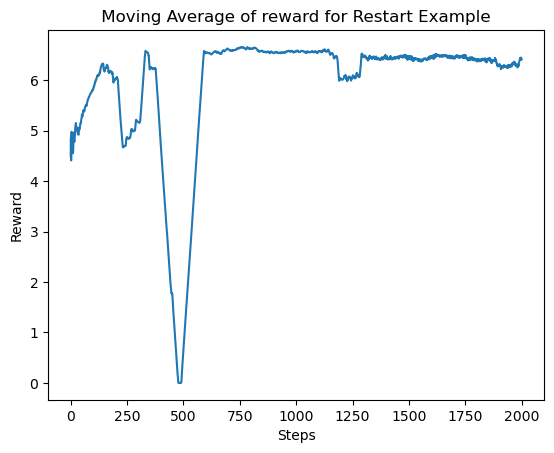

In [38]:
plt.plot(df[0].rolling(100,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Restart Example ')


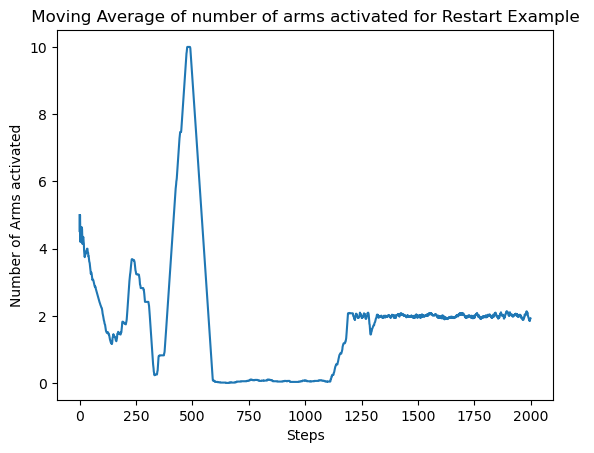

In [39]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(100,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Restart Example ')


In [44]:
x=dqn_solver.model.Qpolicy.predict(np.array([0]).reshape(1,1))
x[0][0][1]-x[0][0][0]

1/1 [==============================] - 0s 19ms/step


-1.3951304

In [50]:
#using learnt indices
current_state=[0 for _ in range(N)]
actual_whittle_indexes=[-0.9,-0.73,-0.5,-0.26,-0.01]
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,1001):
  print(i)
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    temp=dqn_solver.model.Qpolicy.predict(np.array([current_state[index]]).reshape(1,1),verbose=0)
    alternative_indexes[index]=temp[0][0][1]-temp[0][0][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)
  clear_output()

In [63]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
reward_sums_whittle_index=[]

for i in range(1,1001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)


In [64]:
len(reward_sums_whittle_index)

1000

Text(0.5, 1.0, ' Moving Average of reward for Restart Example ')

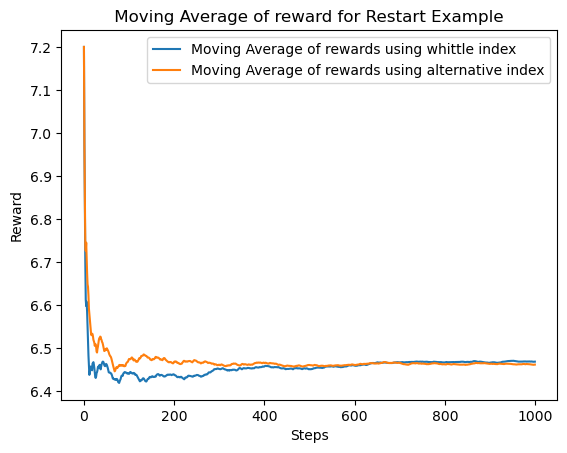

In [65]:
df_rewards=pd.DataFrame()
df_rewards['reward_whittle']=reward_sums_whittle_index
df_rewards['reward_alternate']=reward_sums_alt_index

plt.plot(df_rewards['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df_rewards['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Restart Example ')